In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ArbWellFail: This program calculates the rock strength values required for stable wellbores.
# It replicates figure 8.2 in Zoback's 2007 Textbook.
# Equations come from Peska and Zoback: Failure of Inclined Wellbores (1995)
# Copyright (C) 2017  Chris Dinneen
#
#This program is free software; you can redistribute it and/or
#modify it under the terms of the GNU General Public License
#as published by the Free Software Foundation; either version 2
#of the License, or (at your option) any later version.
#
#This program is distributed in the hope that it will be useful,
#but WITHOUT ANY WARRANTY; without even the implied warranty of
#MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#GNU General Public License for more details.
#
#You should have received a copy of the GNU General Public License
#along with this program; if not, write to the Free Software
#Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.

In [2]:

def plot_polar_contour(values, azimuths, zeniths):
    """Plot a polar contour plot, with 0 degrees at the North.
 
    Arguments:
 
     * `values` -- A list (or other iterable - eg. a NumPy array) of the values to plot on the
     contour plot (the `z` values)
     * `azimuths` -- A list of azimuths (in degrees)
     * `zeniths` -- A list of zeniths (that is, radii)
 
    The shapes of these lists are important, and are designed for a particular
    use case (but should be more generally useful). The values list should be `len(azimuths) * len(zeniths)`
    long with data for the first azimuth for all the zeniths, then the second azimuth for all the zeniths etc.
 
    This is designed to work nicely with data that is produced using a loop as follows:
 
    values = []
    for azimuth in azimuths:
      for zenith in zeniths:
        # Do something and get a result
        values.append(result)
 
    After that code the azimuths, zeniths and values lists will be ready to be passed into this function.
    
    This code was taken from Robin Wilsons Blog.
    Further documentation can be found here: http://blog.rtwilson.com/producing-polar-contour-plots-with-matplotlib/
    
    Some modifications by Chris Dinneen.
    """
    theta = np.radians(azimuths)
    zeniths = np.array(zeniths)
 
    values = np.array(values)
    values = values.reshape(len(azimuths), len(zeniths))
 
    r, theta = np.meshgrid(zeniths, np.radians(azimuths))
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    plt.viridis()
    cax = ax.contourf(theta, r, values, 30)
    plt.viridis()
    cb = fig.colorbar(cax)
    cb.set_label("Required C0")
 
    return fig, ax, cax

In [3]:

def MakePlots(FaultingRegime, S1, S2, S3, PP, MinStressDir, poissonRatio, mudweight ):
    # This function generated does all the calculations and generates the plots.
    # Argument 1. What faulting regime are we in? allowed values are NR, SS or RF
    # Arguments 2-5: values of the principle stresses and pore pressue in MPa
    #    S1              = max Principle Stress
    #    S2              = intermediate principle stress
    #    S3              = minimum principle stress
    #    PP              = pore pressure
    # Argument 6:  Compass direction in degrees of the minimum principle stress 
    # Argument 7:  poissonRatio 
    # Argumnet 8:  Mud Weight in MPa    
    
    if FaultingRegime == 'NF':
        #print("Normal Faulting Regime")
        alpha   =  0+MinStressDir
        beta    =   90
        gamma   =  0
    elif FaultingRegime == 'SS':
        #print("Slip-Strike Faulting Regime")
        alpha   =  90+MinStressDir
        beta    =   0
        gamma   =  90
    elif FaultingRegime == 'RF':
        #print("Reverse Faulting Regime")
        alpha   =  90+MinStressDir
        beta    =   0
        gamma   =  0
    else:
        #print("Unknown Faulting Regime assuming Normal Faulting")
        alpha   =  0+MinStressDir
        beta    =  90
        gamma   =  0
        
    alpha           = np.deg2rad(alpha)
    gamma           = np.deg2rad(gamma)
    beta            = np.deg2rad(beta)
    
    azimuth_list = np.arange(0,360,1)
    inclination_list = np.arange(0,90,1)
    
    MaxStress = []
    MaxStressTheta = []
    for azimuth in azimuth_list:
        azimuth         = np.deg2rad(azimuth)
        for inclination in inclination_list:
            # convert to radians for calcs.
            inclination     = np.deg2rad(inclination)
    
    
            # the input stress tensor
            S = np.matrix(( (S1,0,0), (0,S2,0), (0,0,S3) ))
            
            # the Geographic Transform Matrix
            Rs = np.matrix(( 
            (np.cos(alpha)*np.cos(beta),
            np.sin(alpha)*np.cos(beta),
            -np.sin(beta)),
            
            (np.cos(alpha)*np.sin(beta)*np.sin(gamma)-np.sin(alpha)*np.cos(gamma),
            np.sin(alpha)*np.sin(beta)*np.sin(gamma)+np.cos(alpha)*np.cos(gamma),
            np.cos(beta)*np.sin(gamma)),
            
            (np.cos(alpha)*np.sin(beta)*np.cos(gamma)+np.sin(alpha)*np.sin(gamma),
            np.sin(alpha)*np.sin(beta)*np.cos(gamma)-np.cos(alpha)*np.sin(gamma),
            np.cos(beta)*np.cos(gamma)) ))
            
            # The inclination and azimuth transform matrix
            Rb = np.matrix((
            (-np.cos(azimuth)*np.cos(inclination),-np.sin(azimuth)*np.cos(inclination),np.sin(inclination)),
            (np.sin(azimuth),-np.cos(azimuth),0),
            (np.cos(azimuth)*np.sin(inclination),np.sin(azimuth)*np.sin(inclination),np.cos(inclination) )
            ))
            
            # calculate stress tensor in new geographic coordinate system.
            a = np.dot(np.transpose(Rs),S)
            out= np.dot(a,Rs)
            
            # calculate stress tensor in in wellbore orientation.
            b= np.dot(Rb,out)
            output=np.dot(b,np.transpose(Rb))
            
            #Convert from principle stresses to effective stresses
            # note python arrays start from zero, effective stress notation in paper starts at 1.
            output[0,0]=output.item(0,0)-PP
            output[1,1]=output.item(1,1)-PP
            output[2,2]=output.item(2,2)-PP
            
            # theta is the angle around the wellbore in an arbitrary direction
            theta = np.linspace(0, np.pi, 512)
            
            # stresses in arbitrary wellbore coordinate system
            SigmaZZ = output.item(2,2)-2*poissonRatio*(output.item(0,0)-output.item(1,1))*np.cos(2*theta)-4*poissonRatio*output.item(0,1)*np.sin(2*theta)
            SigmaTheThe = output.item(0,0)+output.item(1,1)-2*(output.item(0,0)-output.item(1,1))*np.cos(2*theta)-4*output.item(0,1)*np.sin(2*theta) -(mudweight-PP)
            SigmaRR = mudweight-PP+theta-theta # this theta bit is to make sure the array is the same size as the other stresses.
            TauTheZ = 2*(output.item(1,2)*np.cos(theta)-output.item(0,2)*np.sin(theta))
            
            # Min and Max hoop stresses around the arbitrary wellbore
            SigmaTMax = 0.5*(SigmaZZ+SigmaTheThe+np.sqrt((SigmaZZ-SigmaTheThe)**2+4*TauTheZ**2))
            SigmaTMin = 0.5*(SigmaZZ+SigmaTheThe-np.sqrt((SigmaZZ-SigmaTheThe)**2+4*TauTheZ**2))
            
            # add the current max stress to the MaxStress Array.
            MaxStress.append(max(SigmaTMax))
            MaxStressTheta.append( np.mod(np.rad2deg(np.argmax(SigmaTMax)/512*(2*np.pi)-np.pi),180))
    
    #Plot Everything
    plt.show(plot_polar_contour(MaxStress,azimuth_list,np.sin(np.deg2rad(inclination_list))))
    #plt.show(plot_polar_contour(MaxStressTheta,azimuth_list,np.sin(np.deg2rad(inclination_list))))

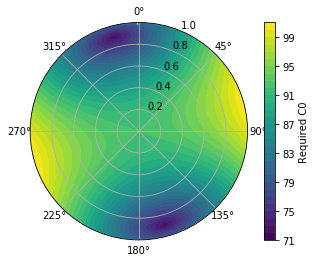

In [4]:
MakePlots("NF", 70, 67, 45, 32, -15, 0.25, 32)

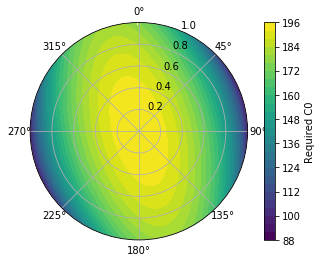

In [5]:
MakePlots("SS", 105, 70, 55, 32, -15, 0.25, 32)

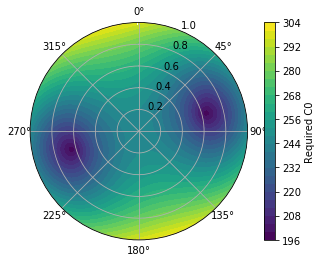

In [6]:
MakePlots("RF", 145, 125, 70, 32, -15, 0.25, 32)